# Offline Sparse PCA

This notebook contains the implementation and debugging of training of sparse PCA in an offline manner.

In [1]:
include("../src/models.jl")

spikedmodel (generic function with 2 methods)

In [2]:
using Plots
using ProgressBars
using LinearAlgebra

In [38]:
p = 1000
N = 120
ω = 1.0
ρ = 0.05
τ = 0.5
β = 0.27
T = 10
σ = 0.0

ξ, spiked = spikedmodel(ρ, p, ω, σ)
X = spiked(N)
Σ = cov(X);

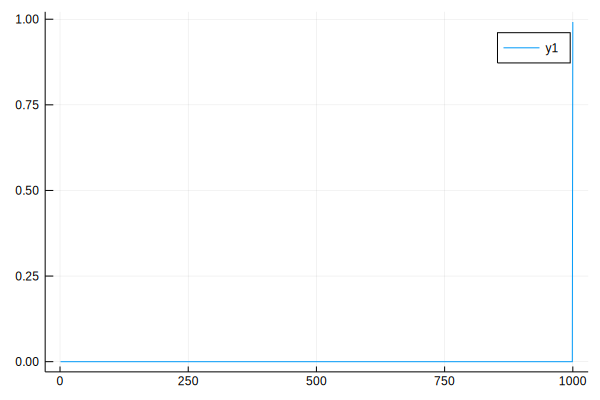

In [39]:
λ = eigvals(Σ)
plot(λ)

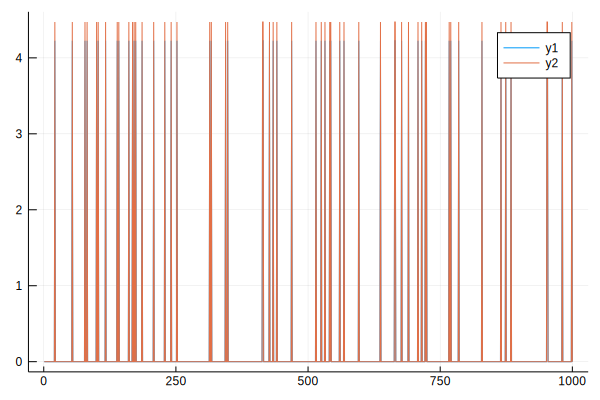

In [40]:
est = eigvecs(Σ)[:, end]
plt = plot(-est * sqrt(p))
plot!(plt, ξ[1, :])

In [41]:
sgn(x) = 2 * convert.(Float64, x .> 0) .- 1
prox(x, β::Float64, p::Int64) = x - (β*sgn(x)/p)
cosinedistance(x, y) = dot(x, y) / (norm(x) * norm(y))

function solve(ξ::Array{Float64, 2}, X::Array{Float64, 2}, T::Int64)
    Σ = cov(X)

    x = randn((1, p)) .* (1/2) .+ 1/sqrt(2)
    Q = zeros(p*T+1)
    Q[1] = cosinedistance(x, ξ)

    for i=ProgressBar(1:p*T)
        x_g = x + (τ/p) .* x * Σ
        prox_x = prox(x_g, β, p)
        x = sqrt(p) * prox_x / norm(prox_x)
        Q[i+1] = cosinedistance(x, ξ)
    end
    return Q, x
end

solve (generic function with 1 method)

In [61]:
n_run = 10

Q = zeros((n_run, p*T+1))

for i=1:n_run
    Q[i,:] = solve(ξ, X, T)[1]
end

100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2441.5 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2610.8 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2579.5 it/s]┫ 2790/10000 [00:01<00:03, 2450.6 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2578.5 it/s]▍                    ┫ 4101/10000 [00:02<00:02, 2628.6 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2508.4 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2476.3 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2577.3 it/s]▌           ┫ 6730/10000 [00:03<00:01, 2533.1 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2514.4 it/s]▊        ┫ 7632/10000 [00:03<00:01, 2536.4 it/s]
100.0%┣█████████████████████████████████┫ 10000/10000 [00:04<00:00, 2523.5 it/s]┫ 8377/10000 [00:03<00:01, 2516.3 it/s]
100.0%┣███████████████████████████

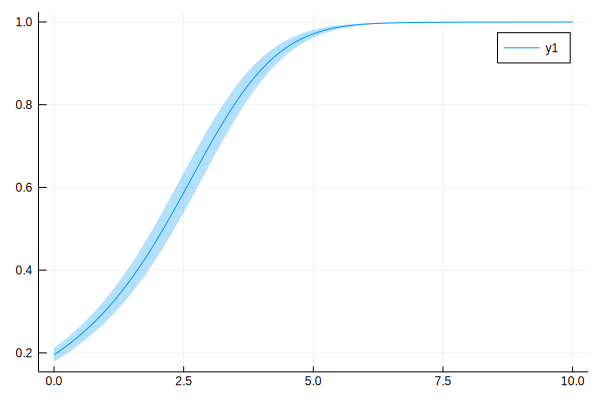

In [76]:
μ_q = mean(Q, dims=1)[1,:]
σ_q = std(Q, dims=1)[1,:]

ts = Array{Float64}(0:T*p) / p

plot(ts, μ_q, ribbon=[σ_q], fillalpha=0.3)

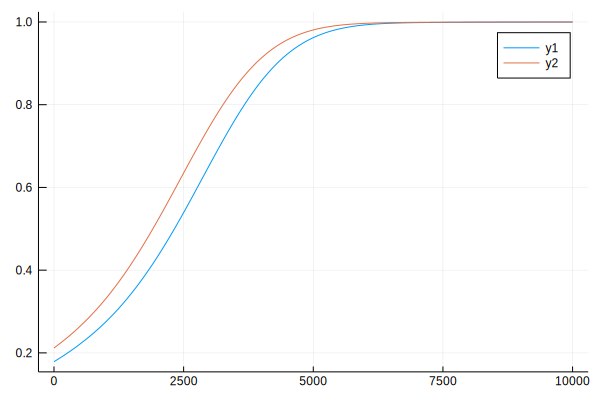

In [69]:
plt=plot(μ_q-σ_q)
plot!(plt, μ_q+σ_q)